# MagPySV example workflow

# Setup

In [1]:
# Setup python paths and import some modules
from IPython.display import Image
import sys
sys.path.append('..')
import os
import datetime as dt

In [2]:
%matplotlib notebook

In [3]:
# Import all of the MagPySV modules
import magpysv.denoise as denoise
import magpysv.inputoutput as inputoutput
import magpysv.model_prediction as model_prediction
import magpysv.svplots as svplots
import magpysv.svtools as svtools

# Initial processing and resampling

Extract all data from the WDC files, convert into the proper daily means using the tabular base and save the X, Y and Z components to CSV files.

In [ ]:
import datetime as dt
import glob
import os
import pandas as pd
import numpy as np
def wdc_to_hourly_csv(*, fpath='./data/BGS_hourly/', write_path, obs_names,
                      print_obs=True):
    """Converts WDC file to X, Y and Z hourly means and save to CSV file.

    Finds WDC hourly data files for all observatories in a directory path
    (assumes data for each observatory is located inside a directory named
    after the observatory). The WDC distributes data inside directories
    with the naming convention /hourval/single_obs/obs/obsyear.wdc where obs is
    a three digit observatory name, year is a four digit year and the string
    /hourval/single_obs prepends each directory name. e.g.
    /hourval/single_obs/ngk/ngk1990.wdc or /hourval/single_obs/clf/clf2013.wdc.
    This function converts the hourly WDC format data to hourly X, Y and Z
    means, appends all years of data for a single observatory into a single
    dataframe and saves the dataframe to a CSV file.

    Args:
        fpath (str): path to the datafiles. Assumes data for each observatory
            is stored in a directory named after the observatory.
        write_path (str): path to which the output CSV files are written.
        print_obs (bool): choose whether to print each observatory name as the
            function goes through the directories. Useful for checking progress
            as it can take a while to read the whole WDC dataset.
    """
    wdc_path = fpath + 'raw_wdc/'
    dir_list = glob.glob(wdc_path)
    obs_names = [os.path.basename(obs_path) for obs_path in dir_list]
    for observatory in obs_names:
        if print_obs is True:
            print(observatory)
        wdc_data = inputoutput.append_wdc_data(
            obs_name=observatory,
            path=fpath + '%s*.wdc')
        inputoutput.write_csv_data(data=wdc_data, write_path=write_path,
                       obs_name=observatory)

In [ ]:
fpath='/Users/gracecox/Desktop/DataDownloads/raw_wdc/'
wdc_path = fpath + 'raw_wdc/'
obs_names = ['UJJ'] #list(stations.keys())[186:]
print_obs = True
write_path='/Users/gracecox/Desktop/DataDownloads/hourly/'
for observatory in obs_names:
    if print_obs is True:
        print(observatory)
    wdc_data = inputoutput.append_wdc_data(
        obs_name=observatory.lower(),
        path=fpath + '%s*.wdc')
    inputoutput.write_csv_data(data=wdc_data, write_path=write_path,
                       obs_name=observatory)

In [ ]:
wdc_to_hourly_csv(fpath='/Users/gracecox/Desktop/DataDownloads/',
                             write_path='/Users/gracecox/Desktop/DataDownloads/hourly/',
                             print_obs=True)

In [ ]:
hourly_data_path = '/Users/gracecox/Desktop/DataDownloads/hourly/'
model_path = './data/model_predictions/'

In [ ]:
for observatory in obs_names:
    print(observatory)
    data_file = observatory + '.csv'
    hourly_data = inputoutput.read_csv_data(
        fname=os.path.join(hourly_data_path, data_file),
        data_type='mf')
    resampled_field_data = svtools.data_resampling(hourly_data)
    correct_baseline_jump(observatory=observatory,
                          field_data=resampled_field_data,
                          jump_data=jump_data)
    inputoutput.write_csv_data(data=resampled_field_data,
                            write_path='/Users/gracecox/Desktop/DataDownloads/monthly_mf/',
                            obs_name=observatory)
    sv_data = svtools.calculate_sv(resampled_field_data,
                                   mean_spacing=1)
#    resampled_field_data.date = resampled_field_data.date.apply(inputoutput.datetime_to_decimal)
    inputoutput.write_csv_data(data=sv_data,
                               write_path='/Users/gracecox/Desktop/DataDownloads/monthly_sv/',
                               obs_name=observatory)

In [ ]:
obs_names = list(sorted(stations.keys()))

In [ ]:
monthly_data_path = '/Users/gracecox/Desktop/DataDownloads/monthly_mf/'
for observatory in obs_names:
    print(observatory)
    data_file = observatory + '.csv'
    mf_data = inputoutput.read_csv_data(
        fname=os.path.join(monthly_data_path, data_file), data_type='mf')
    sv_data = svtools.calculate_sv(mf_data, mean_spacing=12)
    inputoutput.write_csv_data(data=sv_data,
                               write_path='/Users/gracecox/Desktop/DataDownloads/monthly_sv/admm/',
                               obs_name=observatory)

# Field model predictions

We need some secular variation predictions from a geomagnetic field model. This example uses COV-OBS. The following code obtains the complete list of geomagnetic observatory locations from the WDC website, converts the lat/lon in degrees to colat/lon in radians and altitude from m to km, and then runs the COV-OBS model for each location to produce files containing the model prediction of SV and MF at that location.

In [ ]:
stations = model_prediction.get_observatory_list()

In [ ]:
model_prediction.run_covobs(stations=stations, model_path='/Users/gracecox/Dropbox/cov-obs_x1/',
                            output_path='/Users/gracecox/Dropbox/cov-obs_x1/monthly_vals/')

# Residuals

Select a few observatories

In [ ]:
#obs_names = ['esk', 'had', 'ngk'] # European example
#obs_names = ['abk', 'brw', 'cbb', 'cmo', 'hrn', 'sod', 'thl', 'ykc', 'naq', 'nur', 'ler'] # High latitude
#obs_names = ['new', 'frd', 'aia', 'gua', 'clf', 'mbo', 'her', 'kak', 'irt', 'gna', 'bel', 'ngk'] # Mixed locations
#obs_names = ['ngk', 'sjg', 'cmo', 'pst']

In [ ]:
obs_to_ignore = ['ABN', 'BRD', 'CKI', 'CLH', 'CTO', 'DBN', 'EKT',
                 'POT', 'PSM', 'SCO', 'SED', 'TOK', 'VLJ', 'WIA',
                'AGN', 'ALM', 'AMT', 'AMU', 'ARE', 'ARK', 'ASO',
                'BAG', 'BDE', 'BFO', 'BGY', 'BLT', 'BRT', 'BYR',
                'CAO', 'CAX', 'CNH', 'CPA', 'CRP', 'CTX', 'DAL',
                'DAV', 'DED', 'DLT', 'DMC', 'DOB', 'EGS', 'EIC',
                'ETT', 'FAN', 'FRA', 'FSP', 'FTN', 'GAN', 'GCK',
                'GLM', 'GNG', 'GRM', 'GUL', 'HBA', 'HLW', 'HNA',
                'HVN', 'HYB', 'IBD', 'IPM', 'IZN', 'JAI', 'JCO',
                'JRV', 'KEP', 'KHB', 'KMH', 'KOD', 'KOR', 'KPG',
                'KRC', 'LAA', 'LDV', 'LEN', 'LGR', 'LMM', 'LON',
                'LPB', 'LUA', 'LWI', 'LYC', 'MCP', 'MID', 'MLT',
                'MRN', 'MUB', 'NAI', 'NKK', 'NMP', 'NRD', 'NWS',
                'OAS', 'PAB', 'PCU', 'PEG', 'PIO', 'PLR', 'PRU',
                'PTU', 'QGZ', 'QSB', 'QUE', 'QZH', 'RBD', 'ROB',
                'SAB', 'SGE', 'SHL', 'SHU', 'SIL', 'SKT', 'SMG',
                'STO', 'SWI', 'TAH', 'TAL', 'TDC', 'TKH', 'TMK',
                'TND', 'TNG', 'TOL', 'TTB', 'TUN', 'UBA', 'UPS',
                'VQS', 'WAT', 'WHS', 'WIL']
obs_names = [obs for obs in sorted(stations.keys()) if obs not in obs_to_ignore]

In [4]:
obs_names = ['NGK']
fig_path = '/Users/gracecox/Desktop/DataDownloads/denoised_sv/test/'

Concatenate the data for our selected observatories.

In [5]:
start = dt.datetime(1960, 1, 1)
end = dt.datetime(2010, 12, 31)
#start = dt.datetime(2000, 1, 1)
#end = dt.datetime(2010, 12, 31)
obs_data, model_sv_data, model_mf_data = inputoutput.combine_csv_data(
    start_date=start, end_date=end, obs_list=obs_names,
    data_path="/Users/gracecox/Desktop/DataDownloads/monthly_sv/fdmm/",
    model_path="/Users/gracecox/Dropbox/cov-obs_x1/monthly_vals/")

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/pandas/tseries/index.py:817: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex
  "or DatetimeIndex", PerformanceWarning)


In [6]:
dates = obs_data['date']

In [ ]:
t = []
for i in stations.keys():
    if abs(stations[i]["latitude"]) < 25 and i not in obs_to_ignore:
        print(i)
        print(stations[i]["country"])
        print(stations[i]["latitude"])
        t.append(i)

In [ ]:
print(sorted(t))

In [ ]:
print(stations['API'])

In [ ]:
import numpy as np

In [ ]:
mag_pole_colat = np.deg2rad(4)
mag_pole_long = np.deg2rad(-170)
geomag_pole_colat = np.deg2rad(10)
geomag_pole_long = np.deg2rad(-70)

In [ ]:
for i in stations.keys():
    colat = np.deg2rad(90 - stations[i]["latitude"])
    long = np.deg2rad(stations[i]["longitude"])
    mag_colat = np.cos(mag_pole_colat)*np.cos(colat) + np.sin(mag_pole_colat)*np.sin(
        colat)*np.cos(long - mag_pole_long)
    stations[i]["mag_colat"] = round(np.rad2deg(np.arccos(mag_colat)), 1)
    geomag_colat = np.cos(geomag_pole_colat)*np.cos(colat) + np.sin(geomag_pole_colat)*np.sin(
    colat)*np.cos(long - geomag_pole_long)
    stations[i]["geomag_colat"] = round(np.rad2deg(np.arccos(geomag_colat)), 1)

In [ ]:
print(stations['LRV'])

In [ ]:
help(round)
round(15.12234, 1)

In [ ]:
t = []
for i in stations.keys():
    if abs(stations[i]["geomag_colat"]) < 30 and i not in obs_to_ignore:
        print(stations[i]["geomag_colat"], i, stations[i]["country"])
        t.append(i)

# SV plots

In [ ]:
write_path = '/Users/gracecox/Desktop/DataDownloads/monthly_sv/figs_admm//'
for observatory in obs_names:
    fig = svplots.plot_sv(dates=dates, sv=obs_data.filter(regex=observatory),
                    model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 10), font_size=20, label_size=24, plot_legend=True,
                    obs=observatory, save_fig = True, write_path=write_path)
#    plt.savefig(fpath)
#    plt.close(fig)

In [ ]:
for observatory in obs_names:
    svplots.plot_mf(dates=dates, mf=obs_data.filter(regex=observatory),
                    model=model_mf_data.filter(regex=observatory),
                    fig_size=(10, 10), font_size=20, label_size=24, plot_legend=True, obs=observatory)

# Outlier detection

Optionally remove spikes in the data before denoising. Large outliers can affect the denoising process so better to remove them beforehand for some series (i.e. at high latitude observatories).

In [7]:
obs_data.drop(['date'], axis=1, inplace=True)
for column in obs_data:    
    obs_data[column] = denoise.detect_outliers(dates=dates, signal=obs_data[column], obs_name=column,
                                               threshold=2.5,
                                               window_length=72, plot_fig=False, save_fig=False,
                                               write_path='/Users/gracecox/Desktop/DataDownloads/denoised_sv/outliers/')
obs_data.insert(0, 'date', dates)

# External noise removal

Compute the residuals and use the eigenvalues/vectors of the covariance matrix to remove unmodelled external signal (Wardinski & Holme, 2011)

In [8]:
residuals = svtools.calculate_residuals(obs_data=obs_data, model_data=model_sv_data)

In [9]:
model_sv_data.drop(['date'], axis=1, inplace=True)
obs_data.drop(['date'], axis=1, inplace=True)

In [10]:
denoised, proxy, eigenvals, eigenvecs = denoise.eigenvalue_analysis(
    dates=dates, obs_data=obs_data, model_data=model_sv_data, residuals=residuals,
    proxy_number=1)

In [ ]:
denoised

# Denoised SV plots

Plots showing the original SV data, the denoised data (optionally with a running average) and the field model predictions.

<IPython.core.display.Javascript object>


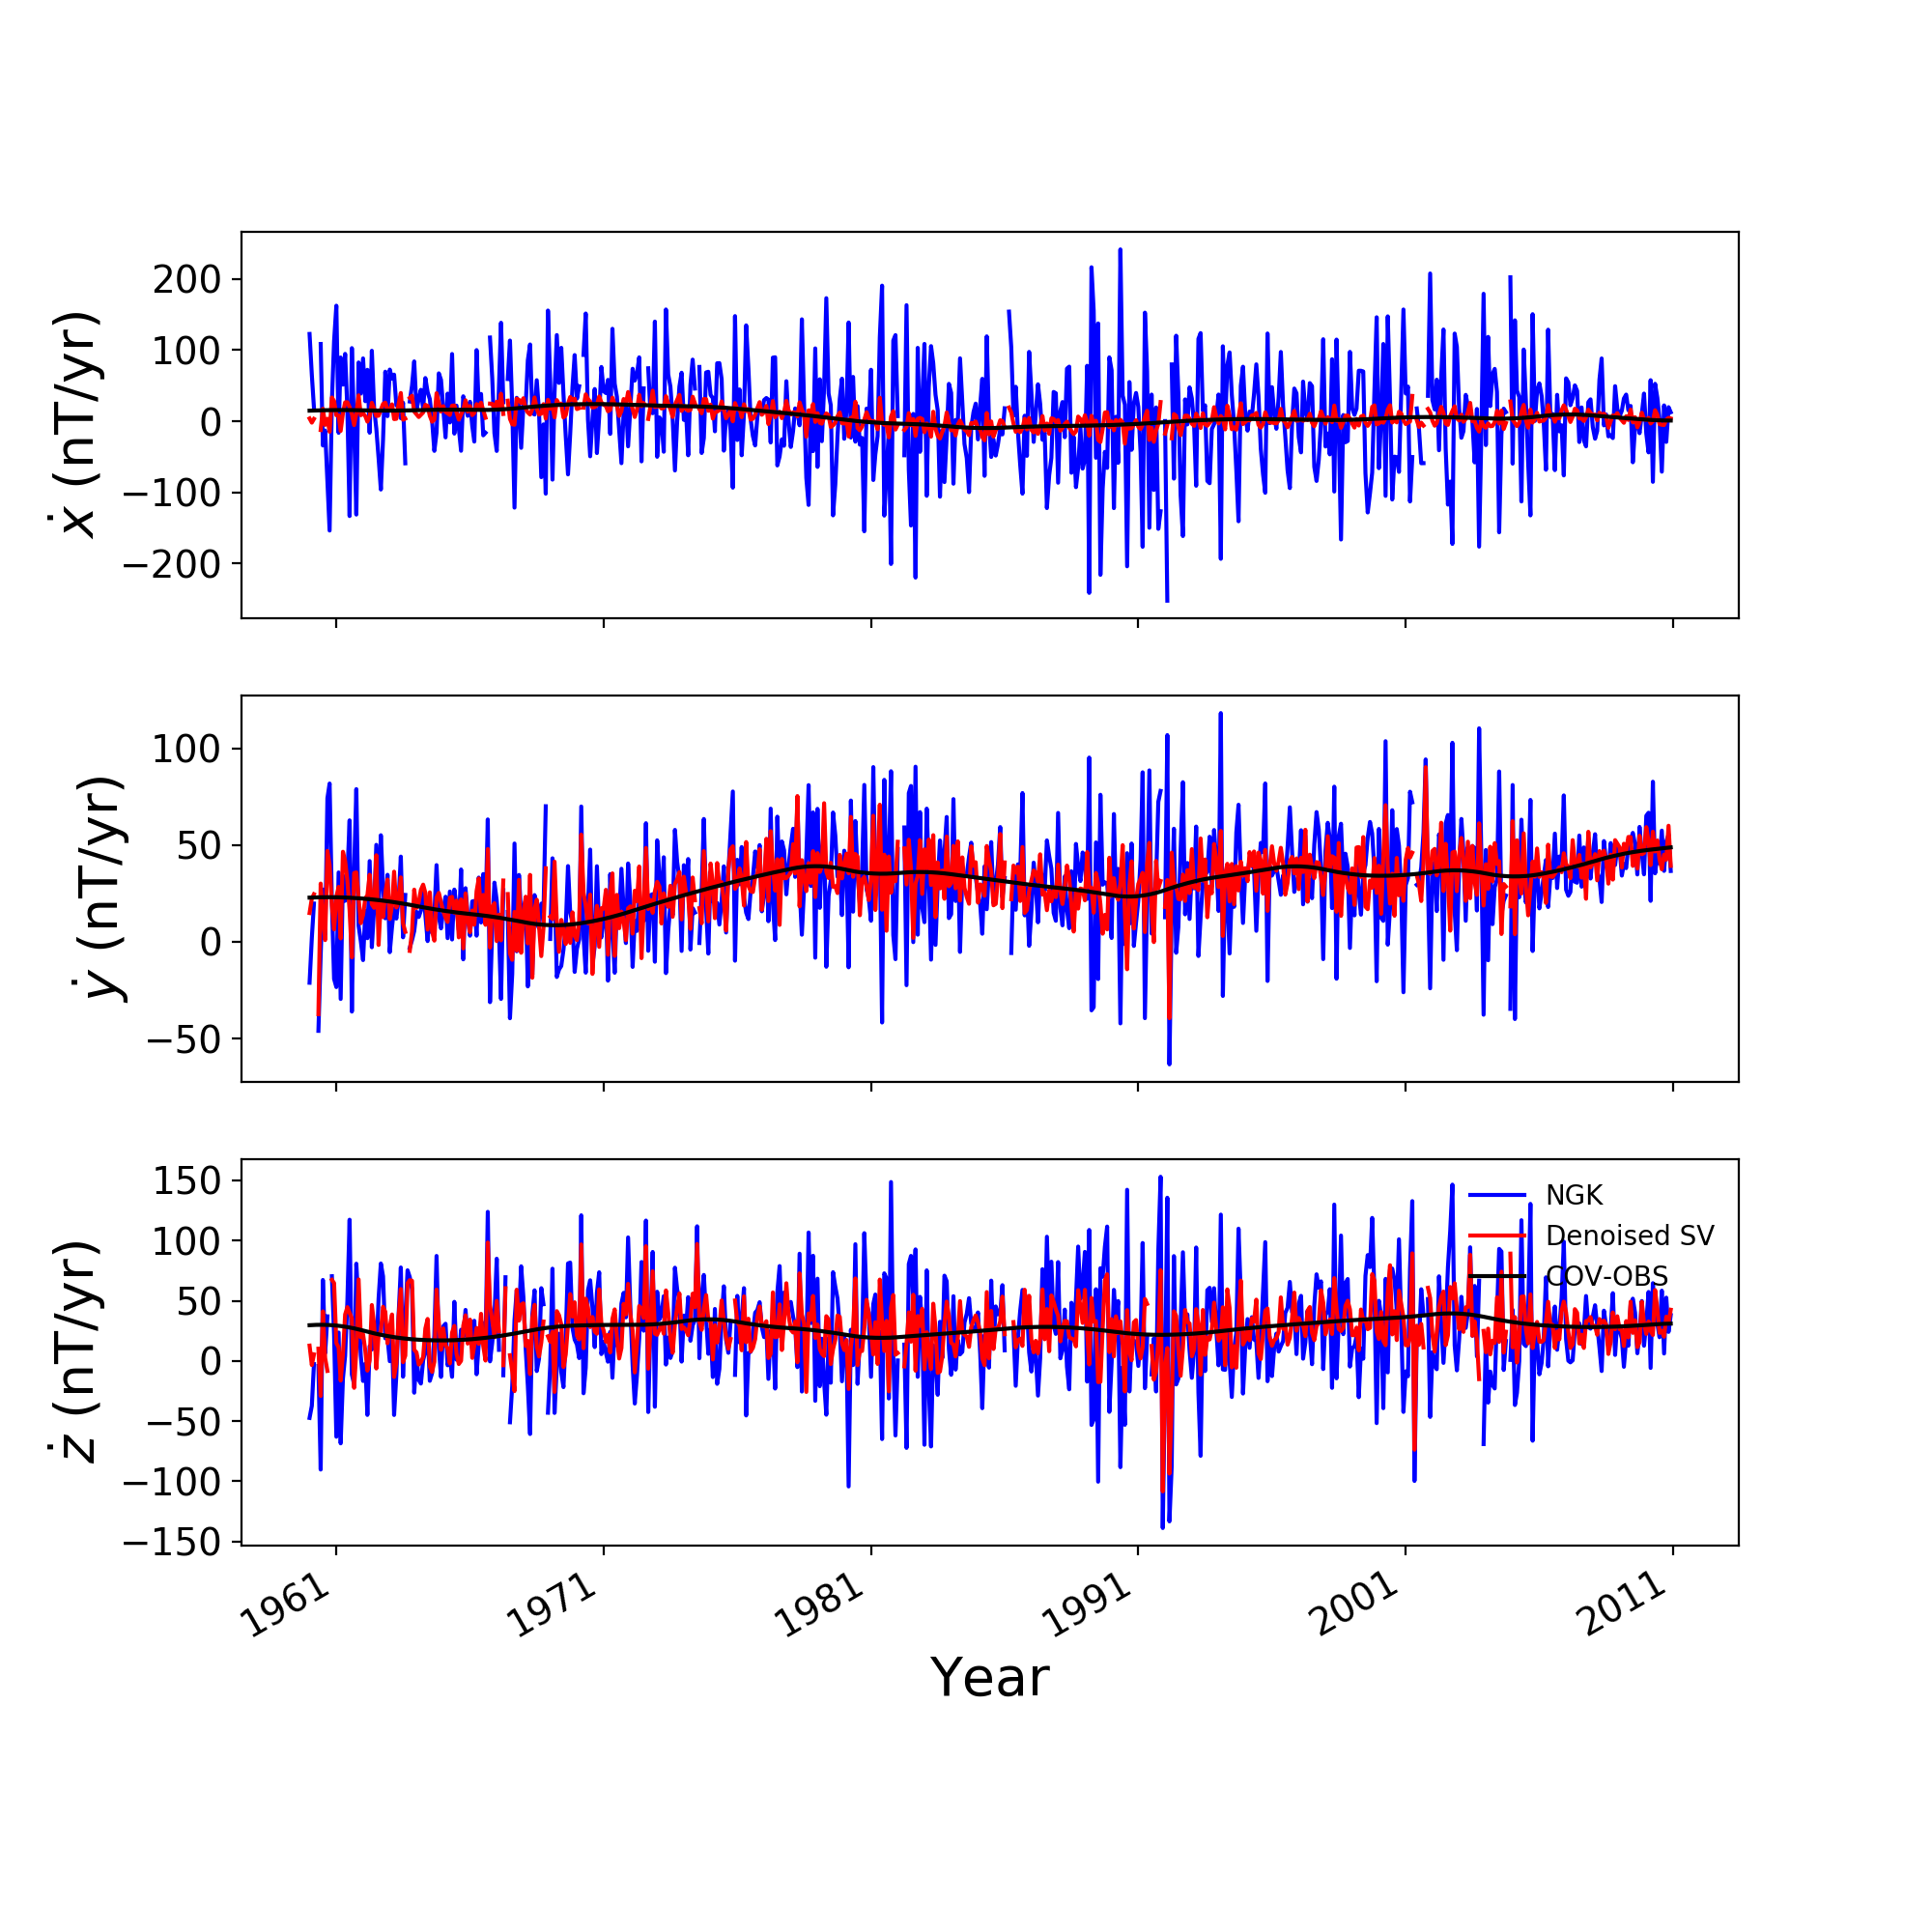

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


In [11]:
for observatory in obs_names:
    svplots.plot_sv_comparison(dates=dates, denoised_sv=denoised.filter(regex=observatory),
                               noisy_sv=obs_data.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 10), font_size=14, label_size=20, plot_legend=True, obs=observatory,
                    plot_average=False, window_length=12, save_fig=False,
                               write_path=fig_path)

Plots showing the denoised data (optionally with a running average) and the field model predictions.

In [ ]:
for observatory in obs_names:
    svplots.plot_sv(dates=dates, sv=denoised.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 10), font_size=16, label_size=20, plot_legend=True, obs=observatory,
                    plot_average=False, window_length=12)

# Plot proxy signal, eigenvalues and eigenvectors

Compare the proxy signal used to denoise the data with the Dcx index (extended, corrected Dst index). Both signals are reduced to zero-mean and unit variance (z-score).

<IPython.core.display.Javascript object>


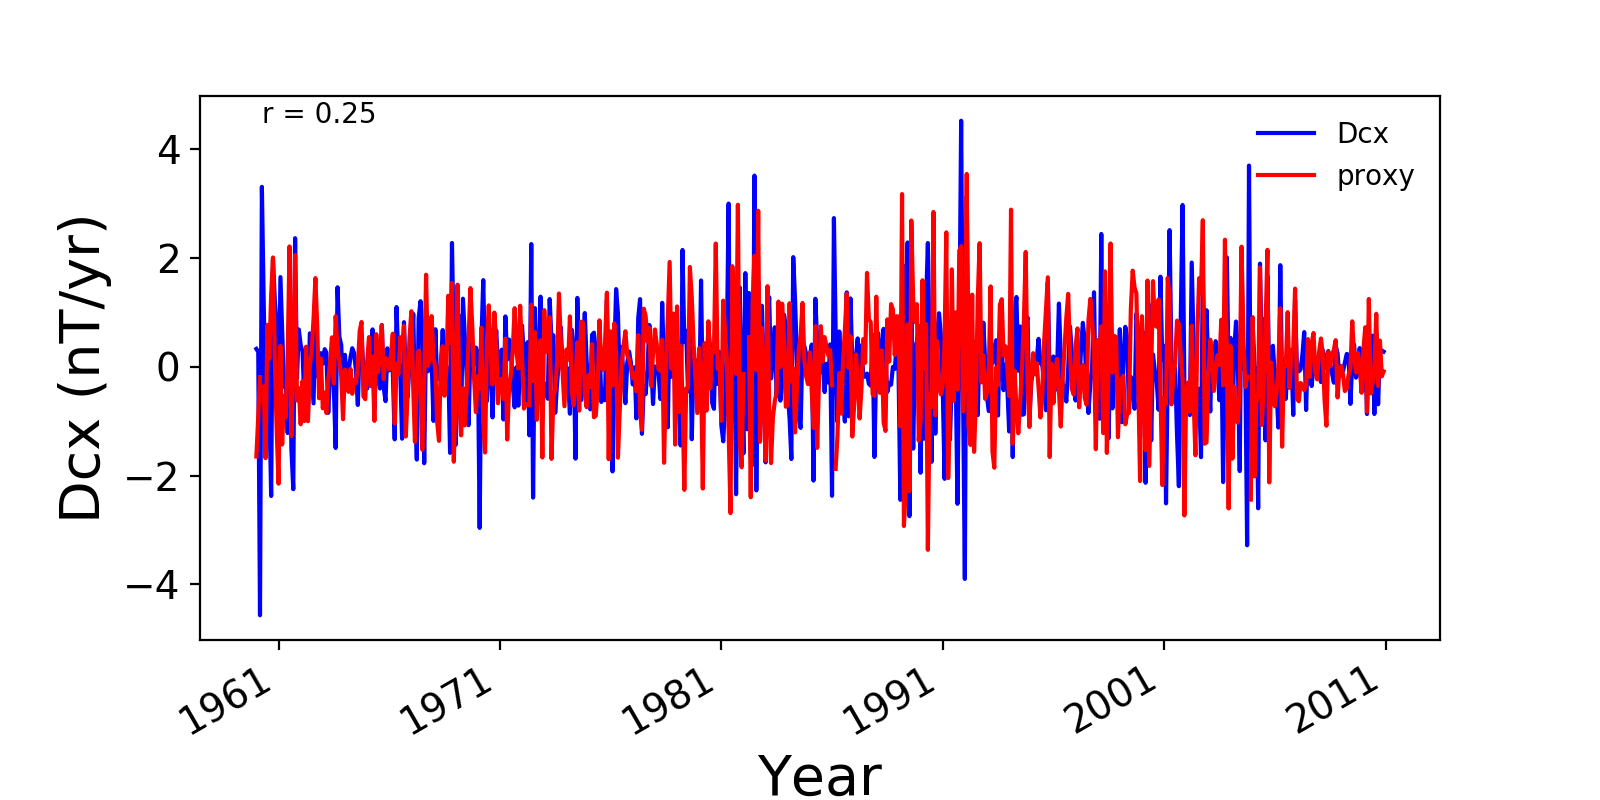

In [13]:
svplots.plot_dcx(dates=denoised.date, signal=proxy, fig_size=(8, 4), font_size=14, label_size=20, plot_legend=True,
                save_fig=False, write_path=fig_path)

Look at the DFT of the proxy signal and Dcx index

<IPython.core.display.Javascript object>


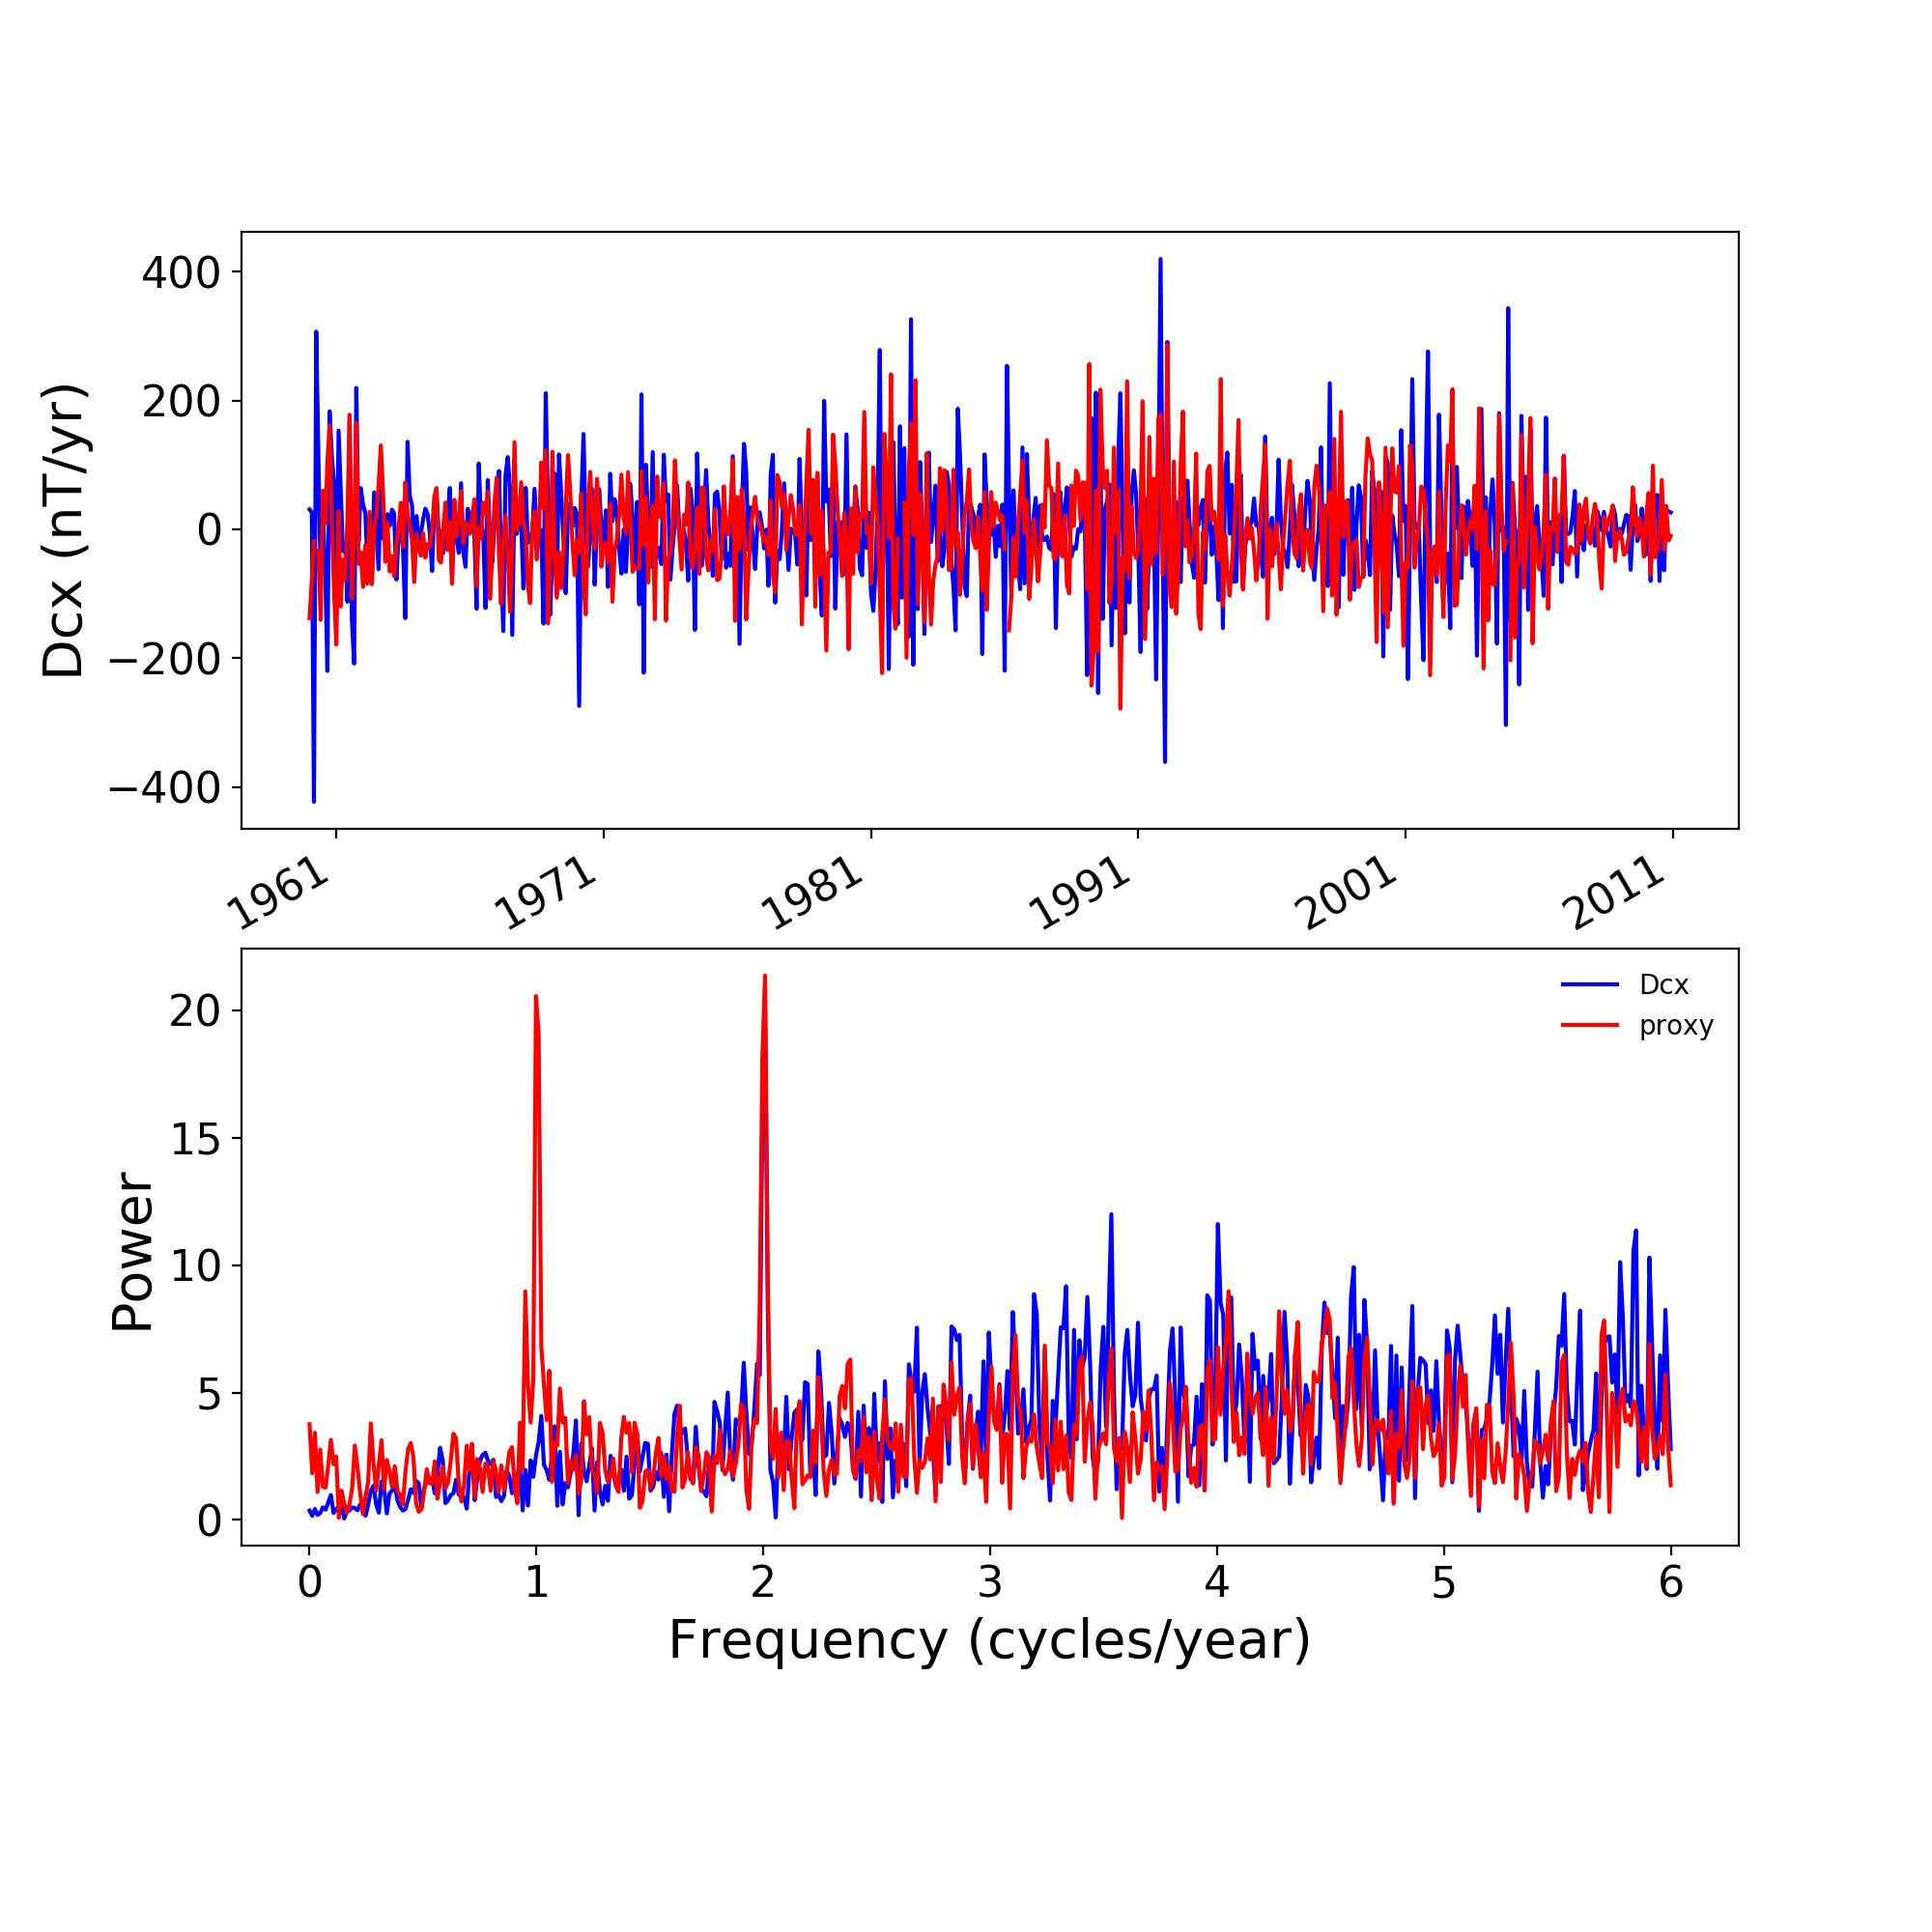

In [14]:
svplots.plot_dcx_fft(dates=denoised.date, signal=proxy, fig_size=(10, 10), font_size=16, label_size=20,
                     plot_legend=True, save_fig=False,
                     write_path=fig_path)

Plot the eigenvalues of the covariance matrix of the residuals

<IPython.core.display.Javascript object>


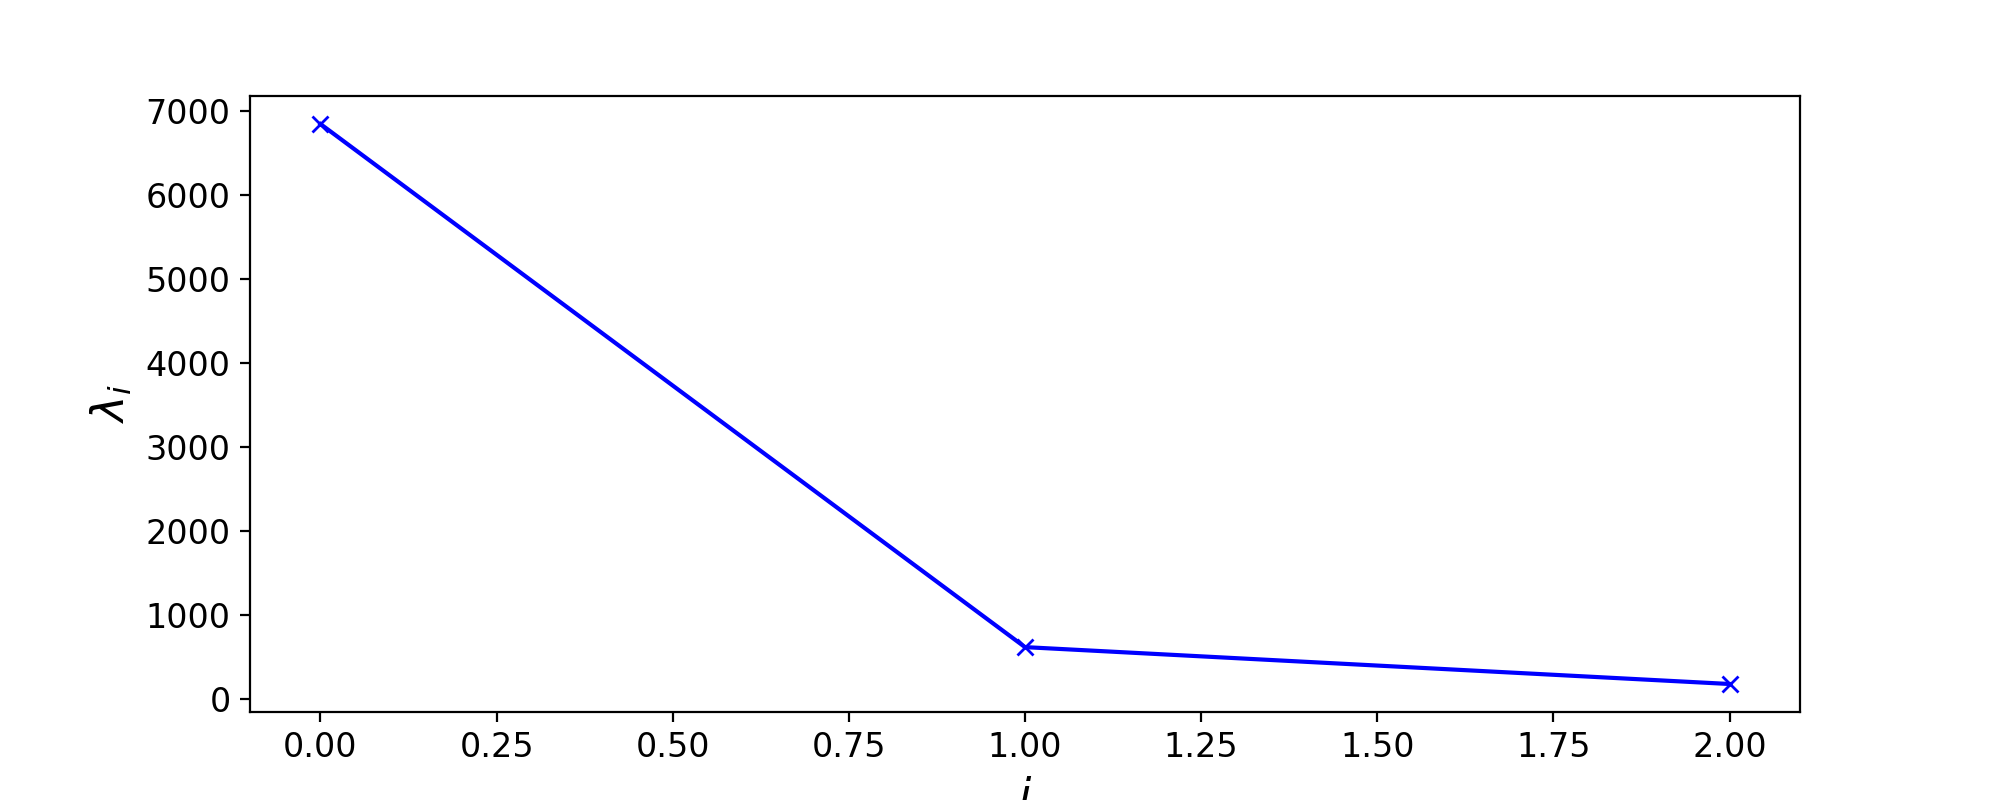

In [15]:
svplots.plot_eigenvalues(values=eigenvals, font_size=12, label_size=16, fig_size=(10, 4), save_fig=False,
                        write_path=fig_path)

Plot the eigenvectors corrresponding to the largest eigenvalue(s)

<IPython.core.display.Javascript object>


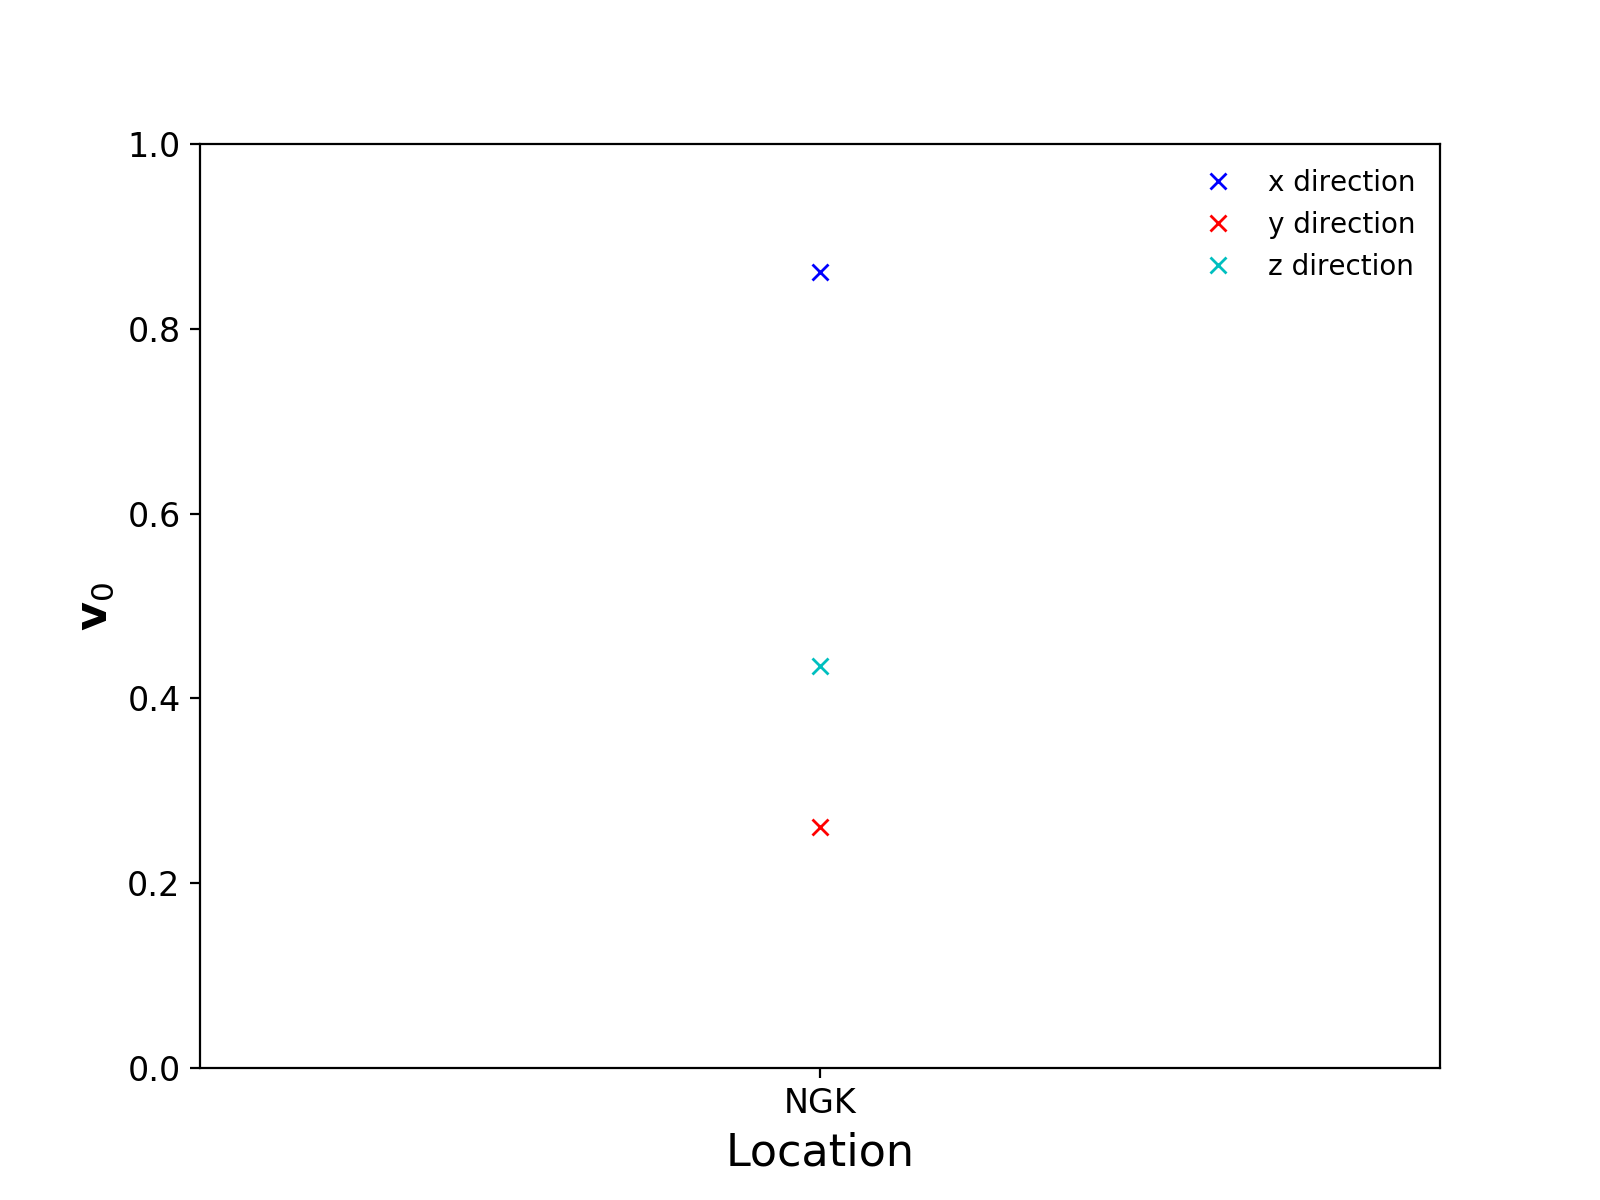

In [16]:
svplots.plot_eigenvectors(obs_names=obs_names, eigenvecs=eigenvecs, save_fig=False,
                          write_path=fig_path)

# Outlier detection

Remove remaining spikes in the time series.

In [ ]:
#denoised.drop(['date'], axis=1, inplace=True)
for column in denoised:
    denoised[column] = denoise.detect_outliers(dates=dates, signal=denoised[column], obs_name=column, threshold=2.5,
                                               window_length=72, plot_fig=True)
denoised.insert(0, 'date', dates)

# Replot denoised SV after outlier removal

In [ ]:
for observatory in obs_names:
    svplots.plot_sv(dates=dates, sv=denoised.filter(regex=observatory), model=model_sv_data.filter(regex=observatory),
                    fig_size=(10, 10), font_size=16, label_size=20, plot_legend=True, obs=observatory,
                    plot_average=False, window_length=12)

# Write denoised data to file

In [ ]:
for observatory in obs_names:
    print(observatory)
    sv_data=denoised.filter(regex=observatory)
    sv_data.insert(0, 'date', dates)
    sv_data.columns = ["date", "dX", "dY", "dZ"]
    inputoutput.write_csv_data(data=sv_data, write_path="/Users/gracecox/Desktop/DataDownloads/denoised_sv/data/",
                               obs_name=observatory, decimal_dates=True)

In [ ]:
plt.figure()
plt.gca().xaxis_date()
df['zscore'] = (df['ae'] - df['ae'].mean())/df['ae'].std(ddof=0)
plt.plot(df['date'], df['zscore'], 'r',
         dcx.date, sp.stats.mstats.zscore(dcx.monthly_mean), 'b')
plt.gcf().autofmt_xdate()
plt.annotate('r = ' + "{:.2f}".format(coeff.data[1, 0]), xy=(0.05, 0.95), xycoords='axes fraction')
plt.savefig('/Users/gracecox/Desktop/DataDownloads/denoised_sv/ae_dcx_zscore.pdf', bbox_inches='tight')

In [ ]:
t1 = pd.merge(left=df, right=dcx,
                how='inner', on='date')

In [ ]:
t1.columns = ['date', 'ae', 'dcx']

In [ ]:
dcx['zscore_dcx'] = sp.stats.mstats.zscore(dcx.monthly_mean)

In [ ]:
t1['zscore_ae'].corr(t1['zscore_dcx'], method='pearson')

In [21]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os
import datetime as dt

In [ ]:
col_names = ['date', 'ae']
ae = pd.read_csv('/Users/gracecox/Desktop/ae_index/means/fdmm.csv',
                sep=',', header=0, names=col_names, parse_dates=[0])

In [ ]:
ae = ae[ae['date'].isin(dcx.date)]

In [ ]:
plt.figure()
plt.plot(ae.date, sp.stats.mstats.zscore(ae['ae']), 'b',
             dates, sp.stats.mstats.zscore(proxy), 'r')

In [ ]:
plt.figure()
plt.plot(ae['date'], ae['ae'], 'r',
         dates, proxy, 'b')
plt.gcf().autofmt_xdate()
plt.annotate('r = ' + "{:.2f}".format(coeff.data[1, 0]), xy=(0.05, 0.95), xycoords='axes fraction')
plt.savefig('/Users/gracecox/Desktop/DataDownloads/denoised_sv/ae_dcx.pdf', bbox_inches='tight')

In [ ]:
np.corrcoef(proxy.data, ae['ae'])

In [29]:
masked_ae = np.ma.array(ae['ae'], mask=np.isnan(ae['ae']))

In [30]:
coeff = np.ma.corrcoef(masked_ae, dcx.monthly_mean, rowvar=False,
                                  allow_masked=True)

In [31]:
round(coeff.data[1, 0], 2)

0.31

In [ ]:
masked_ae.shape

In [ ]:
newer_method_string = "{:.2f}".format(coeff.data[1, 0])

In [ ]:
newer_method_string

<IPython.core.display.Javascript object>


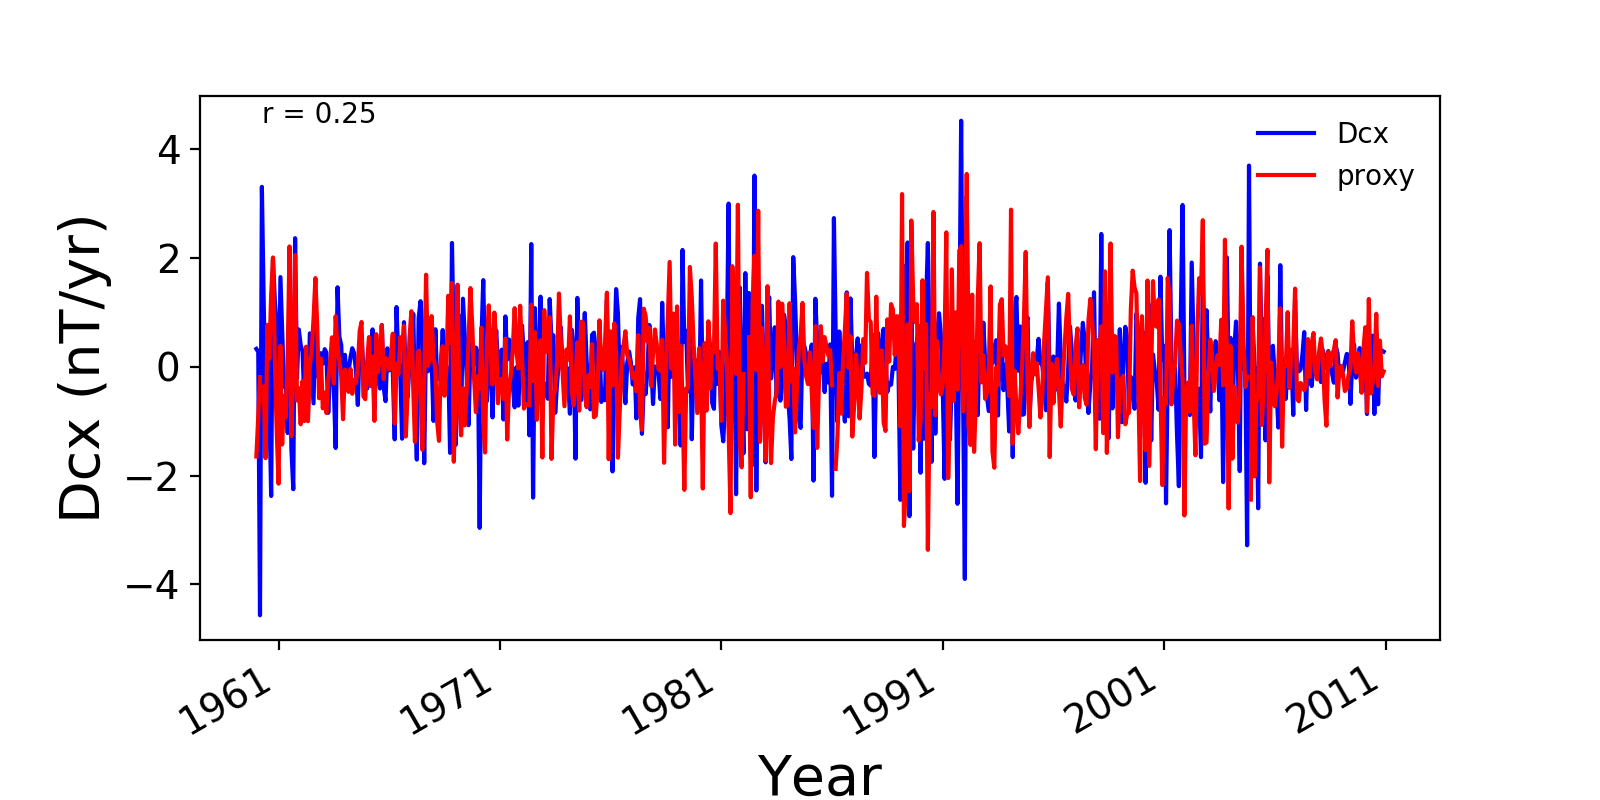

In [32]:
svplots.plot_dcx(dates=denoised.date, signal=proxy, fig_size=(8, 4), font_size=14, label_size=20, plot_legend=True,
                save_fig=False, write_path=fig_path)

<IPython.core.display.Javascript object>


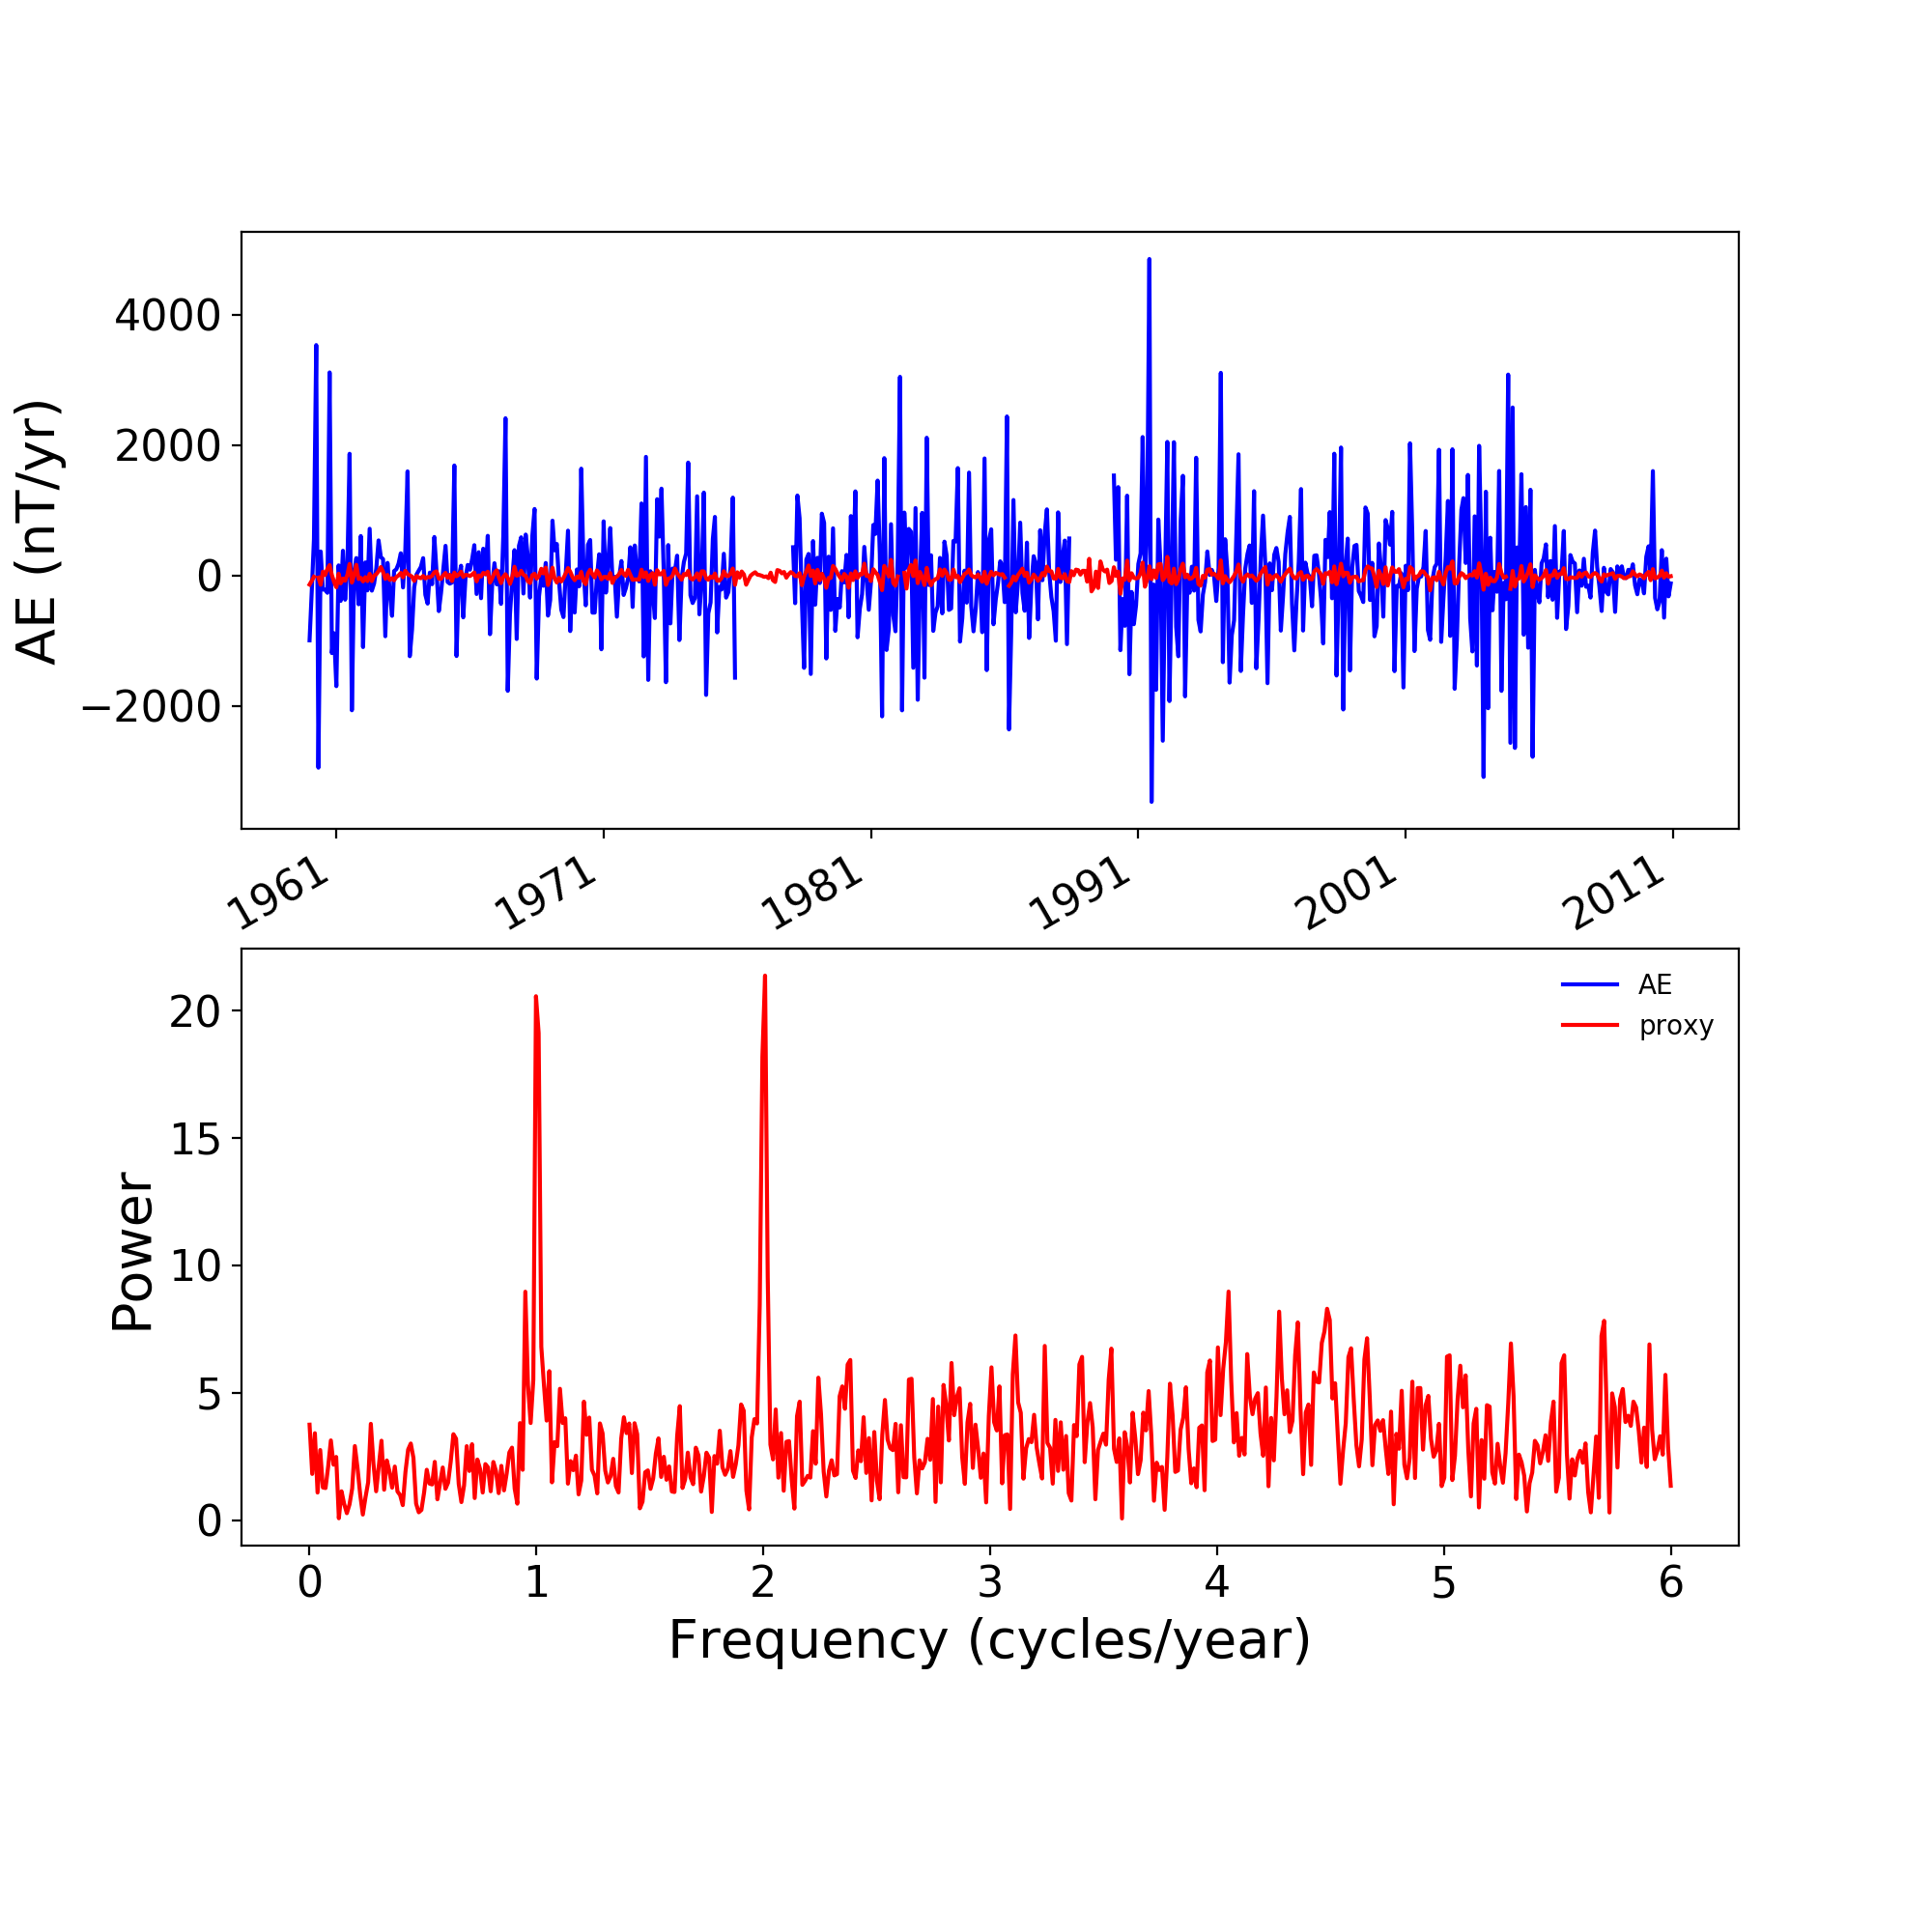

In [19]:
svplots.plot_ae_fft(dates=denoised.date, signal=proxy, fig_size=(10, 10), font_size=16, label_size=20,
                     plot_legend=True, save_fig=False,
                     write_path=fig_path)

In [23]:
signal = proxy
# Read the AE data and put into a dataframe
data_path = '/Users/gracecox/Desktop/ae_index/means'
data_file = 'fdmm.csv'
col_names = ['date', 'ae']
ae = pd.read_csv(os.path.join(data_path, data_file),
                 sep=',', header=0, names=col_names, parse_dates=[0])
# Only keep AE data for dates during the period of interest
ae = ae[ae['date'].isin(dates)]

sampling_period = 1 / 12.0   # Sampling time in years

# Find the next power of two higher than the length of the time series and
# perform the FFT with the series padded with zeroes to this length
sample_length = int(pow(2, np.ceil(np.log2(len(signal)))))
masked_ae = np.ma.array(ae['ae'], mask=np.isnan(ae['ae']))
ae_fft = sp.fft(masked_ae, sample_length)
proxy_fft = sp.fft(signal, sample_length)
freq = np.linspace(0.0, 1.0 / (2.0 * sampling_period), sample_length / 2)
ae_power = (2.0 / sample_length) * np.abs(ae_fft[:sample_length // 2])
proxy_power = (2.0 / sample_length) * np.abs(
    proxy_fft[:sample_length // 2])

/Users/gracecox/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [ ]:
masked_ae.mask

In [ ]:
proxy

In [ ]:
ae

<IPython.core.display.Javascript object>


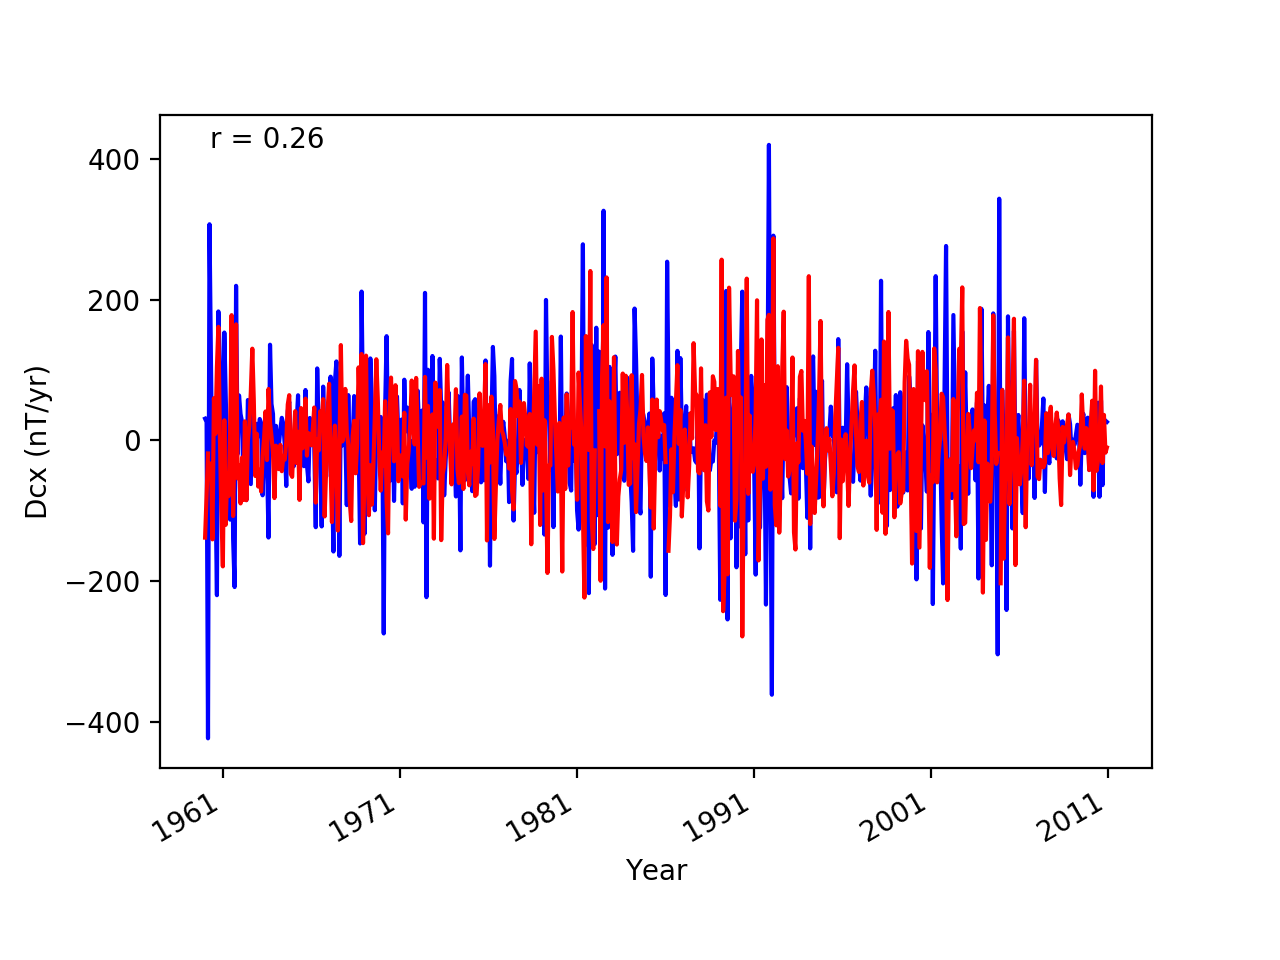

In [28]:
signal = proxy
# Read the Dcx data and put into a dataframe
data_path = '../../Dropbox/BGS_data/monthly_means/Dcx/'
data_file = 'Dcx_mm_monthly_diff.txt'
dcx = pd.read_csv(os.path.join(data_path, data_file), sep=r'\s+',
                  header=None)
dcx.columns = ["year", "month", "monthly_mean"]
dcx_dates = dcx.apply(lambda x: dt.datetime.strptime(
    "{0} {1}".format(int(x['year']), int(x['month'])), "%Y %m"), axis=1)

# Create datetime objects for the series
dcx.insert(0, 'date', dcx_dates)
dcx.drop(dcx.columns[[1, 2]], axis=1, inplace=True)
# Only keep Dcx data for dates during the period of interest
dcx = dcx[dcx['date'].isin(dates)]

masked_dcx = np.ma.array(dcx['monthly_mean'],
                         mask=np.isnan(dcx['monthly_mean']))
coeff = np.ma.corrcoef(masked_dcx, signal, rowvar=False,
                       allow_masked=True)
# Plot the zscore of the two time series
plt.figure()
plt.gca().xaxis_date()
plt.plot(dcx.date, dcx.monthly_mean, 'b',
         dates, signal, 'r')
plt.gcf().autofmt_xdate()
plt.axis('tight')
plt.xlabel('Year')
plt.ylabel('Dcx (nT/yr)')
plt.xticks()
plt.yticks()
plt.annotate('r = ' + "{:.2f}".format(coeff.data[0, 1]), xy=(0.05, 0.95),
             xycoords='axes fraction')

In [24]:
np.corrcoef(dcx.monthly_mean, ae.ae)[0, 1]

nan

In [ ]:
from scipy.stats import linregress
linregress(dcx.monthly_mean, masked_ae)